In [7]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split


#  1. Cargar Datos y Preprocesador/Encoder 


In [3]:

try:
    X_processed = pd.read_csv('./data/processed/X_processed.csv')
    y_processed = pd.read_csv('./data/processed/y_processed.csv').values.ravel() # .ravel() para convertir a 1D
    preprocessor = joblib.load('./models/preprocessor.joblib')
    le_target = joblib.load('./models/label_encoder_target.joblib')
    print("Datos y objetos preprocesados cargados exitosamente.")
except FileNotFoundError as e:
    print(f"Error al cargar archivos: {e}. Asegúrate de ejecutar '01_Data_Preprocessing.ipynb' primero.")
    exit()


Datos y objetos preprocesados cargados exitosamente.



#  2. Definir Pipeline y Espacio de Hiperparámetros 
 El preprocesador es el que cargamos


In [4]:
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))])

param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

#  3. Búsqueda de Hiperparámetros con GridSearchCV


primero divideremos los datos en entrenamiento y en test


In [8]:

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42, stratify=y_processed)

In [ ]:
print("\n--- Iniciando búsqueda de hiperparámetros para Random Forest ---")
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='f1_macro', n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

print("\nMejores hiperparámetros (Random Forest):", grid_search_rf.best_params_)
print("Mejor puntuación F1 Macro (Random Forest):", grid_search_rf.best_score_)
best_rf_model = grid_search_rf.best_estimator_ # El mejor modelo entrenado



--- Iniciando búsqueda de hiperparámetros para Random Forest ---
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Mejores hiperparámetros (Random Forest): {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Mejor puntuación F1 Macro (Random Forest): 0.9402221339486216


In [10]:
print("\nEvaluando el modelo Random Forest en el conjunto de prueba...")
y_pred = best_rf_model.predict(X_test)
print("\nReporte de Clasificación en conjunto de prueba:")
print(classification_report(y_test, y_pred, target_names=le_target.classes_))


Evaluando el modelo Random Forest en el conjunto de prueba...

Reporte de Clasificación en conjunto de prueba:
              precision    recall  f1-score   support

        High       0.96      0.93      0.94       474
         Low       0.98      0.89      0.93       348
      Medium       0.94      0.98      0.96      1178

    accuracy                           0.95      2000
   macro avg       0.96      0.93      0.95      2000
weighted avg       0.95      0.95      0.95      2000



# 5. Curvas de Aprendizaje 

In [18]:
print("\n--- Generando gráfica de convergencia para Random Forest ---")
results_rf = pd.DataFrame(grid_search_rf.cv_results_)
#imprimir columnas del DataFrame
print("Columnas del DataFrame de resultados de GridSearchCV:", results_rf.columns.tolist())



--- Generando gráfica de convergencia para Random Forest ---
Columnas del DataFrame de resultados de GridSearchCV: ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_classifier__max_depth', 'param_classifier__min_samples_leaf', 'param_classifier__min_samples_split', 'param_classifier__n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score']


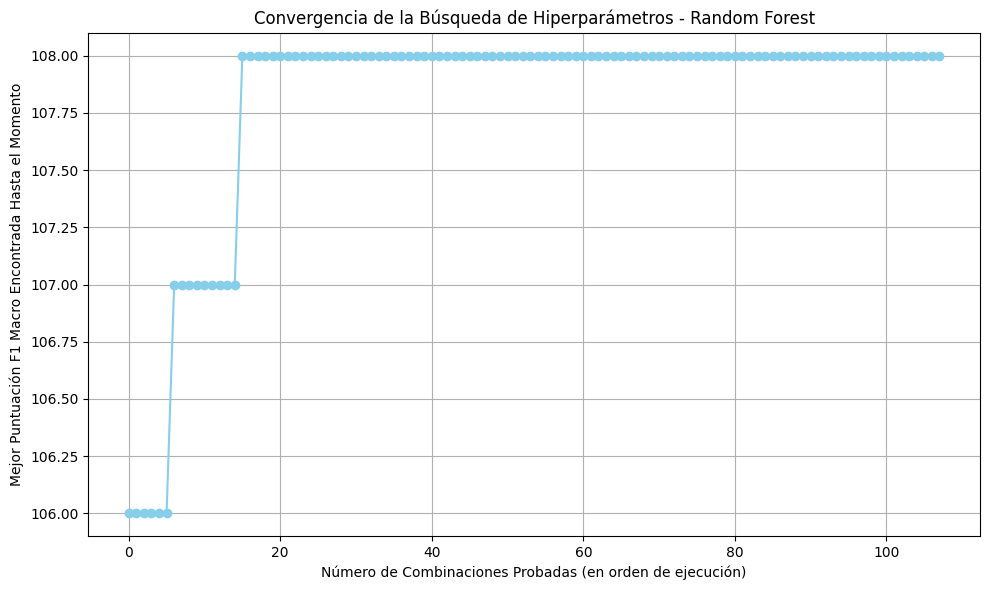

In [ ]:


best_score_so_far_rf = []
current_best_rf = -np.inf # Inicializar con un valor muy bajo

# Iteramos sobre la columna 'mean_test_f1_macro' que sí existe.
# Esta columna contiene la puntuación F1 Macro promedio obtenida por cada combinación.
for score in results_rf['rank_test_score']:
    if score > current_best_rf:
        current_best_rf = score
    best_score_so_far_rf.append(current_best_rf)

plt.figure(figsize=(10, 6))
plt.plot(range(len(best_score_so_far_rf)), best_score_so_far_rf, marker='o', linestyle='-', color='skyblue')
plt.title('Convergencia de la Búsqueda de Hiperparámetros - Random Forest')
plt.xlabel('Número de Combinaciones Probadas (en orden de ejecución)') # Aclara el eje X
plt.ylabel('Mejor Puntuación F1 Macro Encontrada Hasta el Momento')
plt.grid(True)
plt.tight_layout()
plt.show()




--- Generando curvas de aprendizaje para Random Forest ---


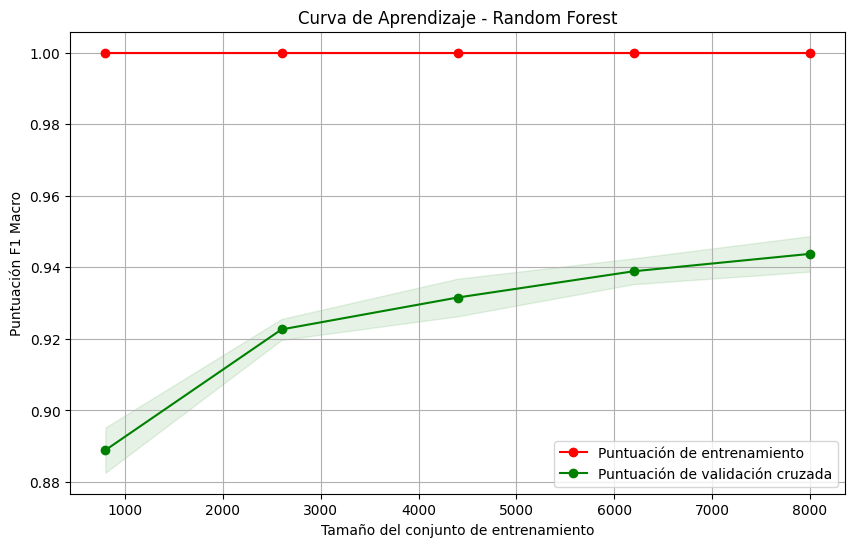

In [12]:
print("\n--- Generando curvas de aprendizaje para Random Forest ---")

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Tamaño del conjunto de entrenamiento")
    axes.set_ylabel("Puntuación F1 Macro")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1_macro'
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Puntuación de entrenamiento")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Puntuación de validación cruzada")
    axes.legend(loc="best")

    return plt

fig, ax = plt.subplots(figsize=(10, 6))
plot_learning_curve(best_rf_model,"Curva de Aprendizaje - Random Forest", X_processed, y_processed, axes=ax, cv=5, n_jobs=-1)
plt.show()



# 6. Guardar el Modelo Entrenado 


In [20]:
joblib.dump(best_rf_model, './models/best_random_forest_model.joblib')
print("Mejor modelo Random Forest guardado en './models/best_random_forest_model.joblib'")

Mejor modelo Random Forest guardado en './models/best_random_forest_model.joblib'
